In [1]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm

## Test importable Dynamic Acceptance Loop

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

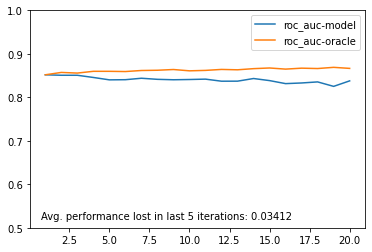

Sampling Bias: 0.03412


In [2]:
n_years = 20

model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)#rinf.EMsemisupervised)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [23]:
print(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years))

0.030117220239442456


## Test importable Autoencoder

In [96]:
import autoencoder as aenc
import var_autoencoder as vaenc
import importlib
importlib.reload(aenc)

<module 'autoencoder' from 'c:\\Projects\\Information-Systems-Seminar\\reject-infer-autoencoder\\notebooks\\../src\\autoencoder.py'>

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=25, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=25, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=68, bias=True)
  )
)
Epoch 1 of 40, Train Loss: 0.5827 (MMSE: 0.9004 | MMD: 0.0000 | KLD: 0.5474)
Epoch 2 of 40, Train Loss: 0.0719 (MMSE: 0.6629 | MMD: 0.0000 | KLD: 0.0062)
Epoch 3 of 40, Train Loss: 0.0609 (MMSE: 0.5702 | MMD: 0.0000 | KLD: 0.0043)
Epoch 4 of 40, Train Loss: 0.0545 (MMSE: 0.5208 | MMD: 0.0000 | KLD: 0.0027)
Epoch 5 of 40, Train Loss: 0.0505 (MMSE: 0.4899 | MMD: 0.0000 | KLD: 0.0017)
Epoch 6 of 40, Train Loss: 0.0479 (MMSE: 0.4706 | MMD: 0.0000 | KLD: 0.0010)
Epoch 7 of 40, Train Loss: 0.0465 (MMSE: 0.4583 | MMD: 0.0000 | KLD: 0.0007)
Epoch 8 of 40, Train Loss: 0.0455 (MMSE: 0.4495 | MMD: 0.0000 | KLD: 0.0006)
Epoch 9 of 40, Train Loss: 0.0448 (MMSE: 0.4429 | MMD: 0.0000 | KLD: 0.0005)
Ep

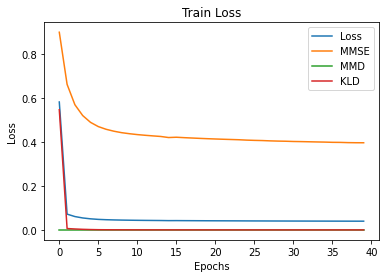

In [97]:
BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3
LOSSFUNCWEIGHTS = [3,1e7, 0.0]  #[MMSE, KLDiv, MMD]

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_loss_mmse, label='MMSE')
plt.plot(train_loss_mmd, label='MMD')
plt.plot(train_loss_kld, label='KLD')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 25)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 25)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 25)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 25)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 25)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 25)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 25)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 25)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 25)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 25)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 25)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 25)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

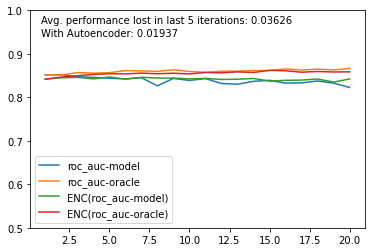

In [98]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

## Plot Parameter-Dependencies

Baseline Sampling Bias: 0.038
Baseline ROC-AUC: 0.82887
PARAM: 10 | Sampling Bias: 0.0199 // ROC-AUC: 0.83292
PARAM: 12 | Sampling Bias: 0.01944 // ROC-AUC: 0.83402
PARAM: 14 | Sampling Bias: 0.02188 // ROC-AUC: 0.83758
PARAM: 16 | Sampling Bias: 0.02712 // ROC-AUC: 0.82982
PARAM: 18 | Sampling Bias: 0.02629 // ROC-AUC: 0.83176
PARAM: 20 | Sampling Bias: 0.03128 // ROC-AUC: 0.82488
PARAM: 22 | Sampling Bias: 0.02385 // ROC-AUC: 0.82868
PARAM: 24 | Sampling Bias: 0.02169 // ROC-AUC: 0.83834
PARAM: 26 | Sampling Bias: 0.02147 // ROC-AUC: 0.8365
PARAM: 28 | Sampling Bias: 0.02486 // ROC-AUC: 0.83497
PARAM: 30 | Sampling Bias: 0.02799 // ROC-AUC: 0.83229
PARAM: 32 | Sampling Bias: 0.02682 // ROC-AUC: 0.83503
PARAM: 34 | Sampling Bias: 0.02583 // ROC-AUC: 0.83254


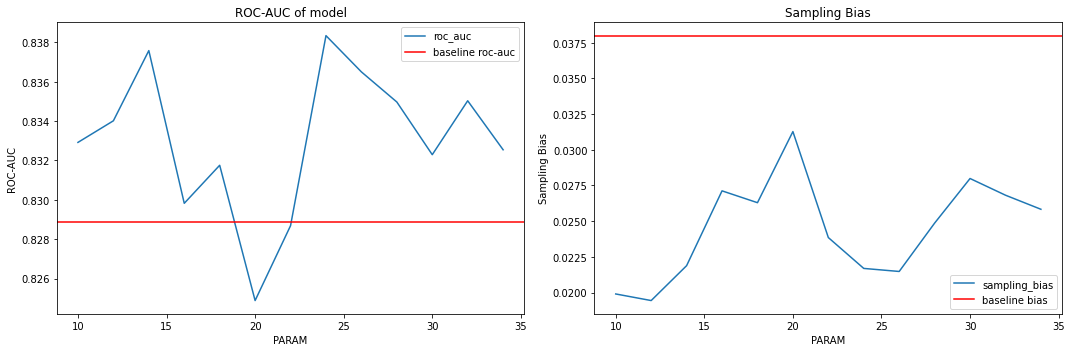

In [100]:
n_years = 20
model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)
datasetname = "gmsc.csv"

## ------------------------------------------------------------
## Get a Baseline Bias Measue without any reject inference
## ------------------------------------------------------------

sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
baseline_bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
baseline_roc_auc = sum(metrics["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Baseline Sampling Bias: {round(baseline_bias, 5)}\nBaseline ROC-AUC: {round(baseline_roc_auc, 5)}')

## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3

sampling_bias = []
roc_auc = []
startvalue = 10
stopvalue = 35
step = 2
for PARAM in range(startvalue, stopvalue, step):
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [0.0, 1.0, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset(datasetname)      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, PARAM, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net = aenc.Autoencoder(shape)
    #print(net)
    net.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose = False)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics2 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics2 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')

# Plot Results
x = range(startvalue, stopvalue, step)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
fig.tight_layout()


mit unseren geratenen 25 schon ganz gut ins schwarze getroffen :D

[0.00000000e+00 1.00050017e-03 8.03208550e-03 2.73678028e-02
 6.60923988e-02 1.33148453e-01 2.41102379e-01 4.09168762e-01
 6.68625110e-01 1.07300656e+00 1.71828183e+00 2.78482632e+00
 4.62938387e+00 7.99797903e+00 1.45490571e+01 2.82242838e+01
 5.90994085e+01 1.35046944e+02 3.40040078e+02 9.51414177e+02
 2.97995799e+03 1.05186477e+04 4.21072937e+04 1.92335169e+05
 1.00852458e+06 6.10732749e+06 4.29694509e+07 3.53360732e+08
 3.41690156e+09 3.90848203e+10]


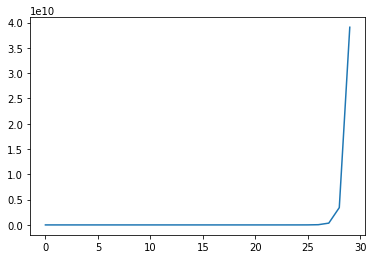

In [31]:
## Testvalues for kldiv size

import numpy as np

test_values = np.expm1(np.array(np.power(range(30),3),"float")/1000)

print(test_values)

plt.plot(test_values)

In [41]:
## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

#test_values = np.array(range(0,10,5))
BATCH_SIZE = 2000
EPOCHS = 10
LR = 1e-3

sampling_bias = []
roc_auc = []

for PARAM in test_values:
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [PARAM, 1, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset(datasetname)      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net2 = aenc.Autoencoder(shape)
    #print(net)
    net2.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = vaenc.train_var(net2, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=True, encoder=net2)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics6 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics6 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics6["oracle"]["holdout"]['roc_auc'], metrics6["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics6["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')


PARAM: 0.0 | Sampling Bias: 0.0235 // ROC-AUC: 0.82915
PARAM: 0.0010005001667083417 | Sampling Bias: 0.03082 // ROC-AUC: 0.82755
PARAM: 0.00803208550427343 | Sampling Bias: 0.02471 // ROC-AUC: 0.83118
PARAM: 0.02736780276348939 | Sampling Bias: 0.02285 // ROC-AUC: 0.83185
PARAM: 0.06609239876150524 | Sampling Bias: 0.02 // ROC-AUC: 0.83687
PARAM: 0.13314845306682632 | Sampling Bias: 0.02439 // ROC-AUC: 0.83106
PARAM: 0.24110237900067172 | Sampling Bias: 0.0215 // ROC-AUC: 0.83623
PARAM: 0.40916876192645085 | Sampling Bias: 0.02864 // ROC-AUC: 0.83043
PARAM: 0.668625110139667 | Sampling Bias: 0.0303 // ROC-AUC: 0.82785
PARAM: 1.073006564260992 | Sampling Bias: 0.02476 // ROC-AUC: 0.83214
PARAM: 1.718281828459045 | Sampling Bias: 0.02488 // ROC-AUC: 0.8314
PARAM: 2.7848263221083744 | Sampling Bias: 0.02425 // ROC-AUC: 0.83373
PARAM: 4.629383874402168 | Sampling Bias: 0.02176 // ROC-AUC: 0.83434
PARAM: 7.997979030914447 | Sampling Bias: 0.02909 // ROC-AUC: 0.82941
PARAM: 14.54905709796590

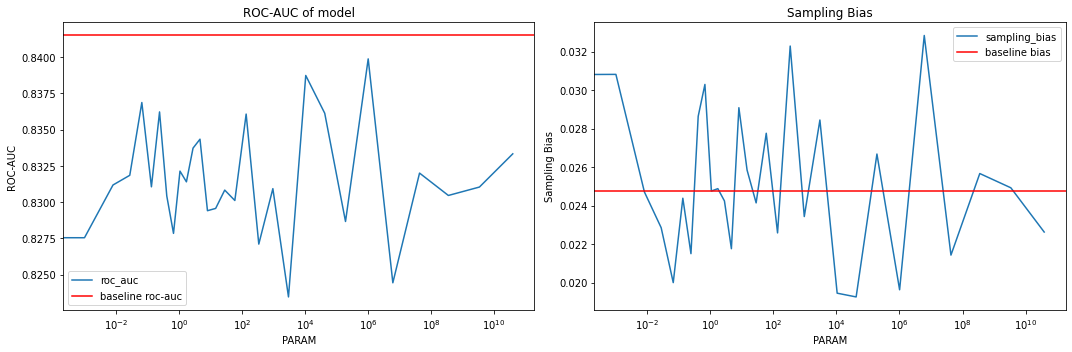

In [43]:

# Plot Results
x = test_values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
axes[0].set_xscale('log')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
axes[1].set_xscale('log')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
fig.tight_layout()


In [81]:
print(test_values[roc_auc > baseline_roc_auc])
print(test_values[roc_auc.index(max(roc_auc))])

[0.00000000e+00 1.33148453e-01 2.41102379e-01 4.09168762e-01
 1.07300656e+00 2.78482632e+00 4.62938387e+00 2.82242838e+01
 5.90994085e+01 2.97995799e+03 1.05186477e+04 4.21072937e+04
 6.10732749e+06 3.53360732e+08 3.90848203e+10]
6107327.490896726


In [83]:
print(test_values[sampling_bias < baseline_bias])
print(test_values[sampling_bias.index(min(sampling_bias))])

[0.00000000e+00 8.03208550e-03 2.73678028e-02 1.33148453e-01
 2.41102379e-01 4.09168762e-01 6.68625110e-01 1.07300656e+00
 1.71828183e+00 2.78482632e+00 4.62938387e+00 7.99797903e+00
 1.45490571e+01 2.82242838e+01 5.90994085e+01 9.51414177e+02
 2.97995799e+03 1.05186477e+04 4.21072937e+04 1.92335169e+05
 1.00852458e+06 6.10732749e+06 3.53360732e+08 3.41690156e+09
 3.90848203e+10]
4.629383874402168


## Test basic Reject Inference Methods

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

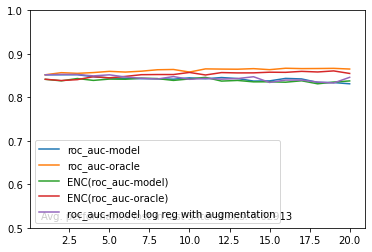

Sampling Bias: 0.02913


In [28]:
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=rinf.augmentation)
results_generator = sim.run()

metrics3 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics3 = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.plot(x, metrics3["model"]["holdout"]['roc_auc'], label = 'roc_auc-model log reg with augmentation')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 34)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 34)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 34)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 34)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 34)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 34)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 34)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 34)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 34)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 34)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 34)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 34)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

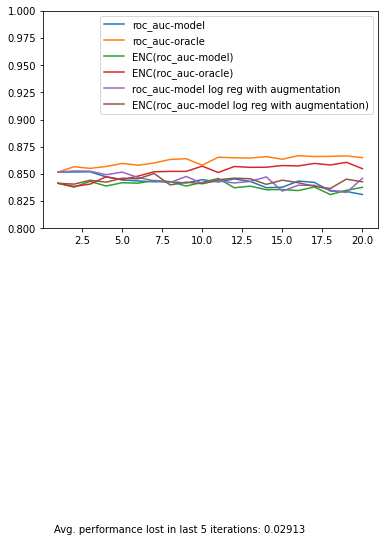

Sampling Bias: 0.02913


In [29]:
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net, rej_inf=rinf.augmentation)
results_generator = sim.run()

metrics4 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics4 = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.plot(x, metrics3["model"]["holdout"]['roc_auc'], label = 'roc_auc-model log reg with augmentation')
plt.plot(x, metrics4["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model log reg with augmentation)')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.8, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [35]:
metrics4["model"]["holdout"]['roc_auc']

[0.8608789133107744,
 0.8602977490179873,
 0.8601653942184185,
 0.8599629019353018,
 0.859719752792211,
 0.8595187565407383,
 0.8591413165571278,
 0.8589952334671783,
 0.858963816802653,
 0.8587888691021593,
 0.8587779568713438,
 0.8586799227977271,
 0.8586854669149963,
 0.8586214015598858,
 0.8585059431177089,
 0.8583310834190766,
 0.8583793964409935,
 0.8582475696525932,
 0.8583145390691305,
 0.8582458096153648]